# 第10章: ベクトル空間法 (II)
第10章では，前章に引き続き単語ベクトルの学習に取り組む．

## 90. word2vecによる学習
81で作成したコーパスに対してword2vecを適用し，単語ベクトルを学習せよ．さらに，学習した単語ベクトルの形式を変換し，86-89のプログラムを動かせ．

In [1]:
!head -n 5 ../../chapter09/work/enwiki-20150112-400-r100-10576-compound_replaced.txt

Anarchism
Anarchism is a political philosophy that advocates stateless societies often defined as self-governed voluntary institutions but that several authors have defined as more specific institutions based on non-hierarchical free associations Anarchism holds the state to be undesirable unnecessary or harmful While anti-statism is central anarchism entails opposing authority or hierarchical organisation in the conduct of human relations including but not limited to the state system
As a subtle and anti-dogmatic philosophy anarchism draws on many currents of thought and strategy Anarchism does not offer a fixed body of doctrine from a single particular world view instead fluxing and flowing as a philosophy There are many types and traditions of anarchism not all of which are mutually exclusive Anarchist schools of thought can differ fundamentally supporting anything from extreme individualism to complete collectivism Strains of anarchism have often been divided into the categories of

In [2]:
from gensim.models.word2vec import LineSentence, Word2Vec
from gensim.test.utils import datapath

sentences = LineSentence('../../chapter09/work/enwiki-20150112-400-r100-10576-compound_replaced.txt')
model = Word2Vec(sentences, size=100, window=5, min_count=10, sg=1, hs=0, negative=5, workers=4)
model.save('../work/word2vec_d100_w5_sg.model')

In [3]:
from gensim.models.word2vec import Word2Vec

def knock_90():
    model = Word2Vec.load("../work/word2vec_d100_w5_sg.model")
    print("United_States の単語ベクトル:")
    print(model.wv["United_States"])
    
    print("\nUnited_States と U.S の類似度:")
    print(model.wv.similarity("United_States", "U.S"))

    print("\nEngland と類似度の高い単語10件")
    print(model.wv.most_similar(positive=['England'], topn=10))
    
    print("\nSpain - Madrid + Athens と類似度の高い単語10件")
    print(model.wv.most_similar(positive=["Spain", "Athens"], negative=["Madrid"], topn=10))
    
knock_90()

United_States の単語ベクトル:
[ 0.04689784 -0.35527393  0.48651475 -0.27428642  0.2615004  -0.35246485
 -0.06216653  0.47134626  0.04878591  0.02839601  0.06492157  0.17200787
 -0.6448097  -0.0872784   0.3021704  -0.08008718 -0.21360594  0.03811397
  0.5330129   0.12069564  0.48625103 -0.42911252  0.24458684 -0.32052618
  0.01678986 -0.20066084  0.45386082 -0.15686424  0.49353206 -0.9327724
 -0.47340834 -0.16791452  0.0960497  -0.5932884  -0.16996618 -0.17338891
  0.40626916  0.21371572  0.48860532 -0.18517935  0.626914   -0.05727199
  0.2272262  -0.58804375 -0.26984704  0.46944955  0.2687874  -0.06591565
  0.12414699  0.14061455  0.10063405  0.16472465 -0.16164117 -0.25586948
  0.2165578  -0.26026306 -0.11949007  0.54176146 -0.47977123  0.16991381
  0.01920626  0.25949425 -0.2327697   0.25655222  0.61307263  0.07513472
 -0.04534547 -0.5667278  -0.08443045  0.08063264  0.06150142 -0.30821908
  0.08242644  0.25228938  0.04550818 -0.3243936  -0.24573816 -0.12345239
  0.01396109 -0.02515759  0.1

## 91. アナロジーデータの準備
単語アナロジーの評価データをダウンロードせよ．このデータ中で": "で始まる行はセクション名を表す．例えば，": capital-common-countries"という行は，"capital-common-countries"というセクションの開始を表している．ダウンロードした評価データの中で，"family"というセクションに含まれる評価事例を抜き出してファイルに保存せよ．

In [4]:
def knock_91():
    with open("../data/questions-words.txt") as f_in, open("../work/questions-words-family.txt", "w") as f_out:
        is_family = False
        for line in f_in:
            if line.startswith(": family"):
                is_family = True
                continue
            if line.startswith(": ") and is_family:
                break
            if is_family:
                f_out.write(line)

knock_91()

## 92. アナロジーデータへの適用
91で作成した評価データの各事例に対して，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．このプログラムを85で作成した単語ベクトル，90で作成した単語ベクトルに対して適用せよ．

In [5]:
import pickle
from functools import lru_cache
from gensim.models.word2vec import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

with open('../../chapter09/work/word_vector.pkl', 'rb') as f:
    word_vectors_85 = pickle.load(f)
with open('../../chapter09/work/word_to_index.pkl', 'rb') as f:
    word_to_index_85 = pickle.load(f)
index_to_word_85 = { index:word for word,index in word_to_index_85.items() }

model_90 = Word2Vec.load("../work/word2vec_d100_w5_sg.model")


def get_similar_word_and_vector_knock_85(base_word, minus_word, plus_word):
    base_word_vector = word_vectors_85[word_to_index_85[base_word.lower()]]
    minus_word_vector = word_vectors_85[word_to_index_85[minus_word.lower()]]
    plus_word_vector = word_vectors_85[word_to_index_85[plus_word.lower()]]
    target_vector = base_word_vector - minus_word_vector + plus_word_vector
    
    cosine_similarities = cosine_similarity(word_vectors_85, target_vector.reshape(1, -1))
    most_similar_index = cosine_similarities.argmax()
    word = index_to_word_85[most_similar_index]
    score = cosine_similarities[most_similar_index][0]
    return word, score

def get_similar_word_and_vector_knock_90(base_word, minus_word, plus_word):
    return model_90.wv.most_similar(positive=[base_word, plus_word], negative=[minus_word], topn=1)[0]

def knock_92():
    with open("../work/questions-words-family.txt") as f_in, open("../work/questions-words-family-85.txt", "w") as f_out_85, open("../work/questions-words-family-90.txt", "w") as f_out_90:
        for line in f_in:
            minus, base, plus, answer = line.rstrip().split()
            try:
                pred_word_85, pred_similarity_85 = get_similar_word_and_vector_knock_85(base, minus, plus)
                f_out_85.write(" ".join([minus, base, plus, answer, pred_word_85, str(pred_similarity_85)]).rstrip() + "\n")
            except KeyError:
                pass
            
            try:
                pred_word_90, pred_similarity_90 = get_similar_word_and_vector_knock_90(base, minus, plus)
                f_out_90.write(" ".join([minus, base, plus, answer, pred_word_90, str(pred_similarity_90)]).rstrip() + "\n")
            except KeyError:
                pass
            
knock_92()

In [6]:
!head -n 5 ../work/questions-words-family-85.txt

boy girl brother sister brother 0.9368151100011339
boy girl brothers sisters brothers 0.8131522467553747
boy girl dad mom dad 0.7552971447268428
boy girl father mother father 0.9078753940438338
boy girl grandfather grandmother grandfather 0.7172331960659377


In [7]:
!head -n 5 ../work/questions-words-family-90.txt

boy girl brother sister uncle 0.6909681558609009
boy girl brothers sisters sisters 0.7478694319725037
boy girl dad mom mom 0.8020932078361511
boy girl father mother mother 0.8092390298843384
boy girl grandfather grandmother granddaughter 0.7770950198173523


## 93. アナロジータスクの正解率の計算
92で作ったデータを用い，各モデルのアナロジータスクの正解率を求めよ．

In [8]:
import pandas as pd

def calc_accuracy(file_path):
    df = pd.read_csv(file_path, names=("minus", "base", "plus", "answer", "pred", "similarity"), delim_whitespace=True)
    return sum(1 for pred, answer in zip(list(df["pred"]),list(df["answer"])) if pred == answer) / float(len(list(df["answer"])))
    
def knock_93():
    print("正解率 (SVD): " + str(calc_accuracy("../work/questions-words-family-85.txt")))
    print("正解率 (Word2Vec): " + str(calc_accuracy("../work/questions-words-family-90.txt")))
    
knock_93()

正解率 (SVD): 0.045454545454545456
正解率 (Word2Vec): 0.5275


## 94. WordSimilarity-353での類似度計算
The WordSimilarity-353 Test Collectionの評価データを入力とし，1列目と2列目の単語の類似度を計算し，各行の末尾に類似度の値を追加するプログラムを作成せよ．このプログラムを85で作成した単語ベクトル，90で作成した単語ベクトルに対して適用せよ．

In [9]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

with open('../../chapter09/work/word_vector.pkl', 'rb') as f:
    word_vectors_85 = pickle.load(f)
with open('../../chapter09/work/word_to_index.pkl', 'rb') as f:
    word_to_index_85 = pickle.load(f)

model_90 = Word2Vec.load("../work/word2vec_d100_w5_sg.model")

def calc_similarity_knock_85(word1, word2):
    word1_vector = word_vectors_85[word_to_index_85[word1.lower()]]
    word2_vector = word_vectors_85[word_to_index_85[word2.lower()]]
    return cosine_similarity(word1_vector.reshape(1, -1), word2_vector.reshape(1, -1))[0][0]
    
def calc_similarity_knock_90(word1, word2):
    return model_90.wv.similarity(word1, word2)

def knock_94():
    df = pd.read_csv("../data/combined.csv", header=0, names=("word1", "word2", "human"))
    similarities_85 = []
    similarities_90 = []
    for i, series in df.iterrows():
        try:
            similarities_85.append(calc_similarity_knock_85(series["word1"], series["word2"]))
        except KeyError:
            similarities_85.append(0.0)

        try:
            similarities_90.append(calc_similarity_knock_90(series["word1"], series["word2"]))
        except KeyError:
            similarities_90.append(0.0)

    df_85 = df.assign(SVD=similarities_85)
    df_85.to_csv("../work/combined_85.csv", index=False)

    df_90 = df.assign(W2V=similarities_90)
    df_90.to_csv("../work/combined_90.csv", index=False)
            
knock_94()

In [10]:
!head -n 10 ../work/combined_85.csv

word1,word2,human,SVD
love,sex,6.77,0.1360884967761282
tiger,cat,7.35,0.14304522661330463
tiger,tiger,10.0,0.9999999999999998
book,paper,7.46,0.3258859130314401
computer,keyboard,7.62,0.07702242545008264
computer,internet,7.58,0.3721741081499508
plane,car,5.77,0.3527340473215006
train,car,6.31,0.11697239922463508
telephone,communication,7.5,0.12173564094038444


In [11]:
!head -n 10 ../work/combined_90.csv

word1,word2,human,W2V
love,sex,6.77,0.48897022008895874
tiger,cat,7.35,0.7160777449607849
tiger,tiger,10.0,1.0
book,paper,7.46,0.5071678757667542
computer,keyboard,7.62,0.550646960735321
computer,internet,7.58,0.6141799688339233
plane,car,5.77,0.4873447120189667
train,car,6.31,0.6109594106674194
telephone,communication,7.5,0.5559662580490112


## 95. WordSimilarity-353での評価
94で作ったデータを用い，各モデルが出力する類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ．

In [12]:
from scipy.stats import spearmanr

def knock_95():
    df_85 = pd.read_csv("../work/combined_85.csv", header=0, names=("word1", "word2", "human", "svd"))
    correlation_85, p_value_85 = spearmanr(list(df_85["human"]), list(df_85["svd"]))
    
    df_90 = pd.read_csv("../work/combined_90.csv", header=0, names=("word1", "word2", "human", "w2v"))
    correlation_90, p_value_90 = spearmanr(list(df_90["human"]), list(df_90["w2v"]))

    print("相関係数 (SVD): " + str(correlation_85))
    print("相関係数 (Word2Vec): " + str(correlation_90))

knock_95()

相関係数 (SVD): 0.2804637374588378
相関係数 (Word2Vec): 0.5809969538494227


## 96. 国名に関するベクトルの抽出
word2vecの学習結果から，国名に関するベクトルのみを抜き出せ．

In [13]:
from sklearn.externals import joblib

model_90 = Word2Vec.load("../work/word2vec_d100_w5_sg.model")

def knock_96():
    with open("../../chapter09/data/countries") as f_country:
        country_names = []
        country_vectors = []
        for line in f_country:
            try:
                country_name = line.rstrip().replace(" ", "_")
                country_vectors.append(model_90.wv[country_name])
                country_names.append(country_name)
            except KeyError:
                pass

        joblib.dump(country_names, "../work/country_names.pkl")
        joblib.dump(country_vectors, "../work/country_vectors.pkl")
            
knock_96()

## 97. k-meansクラスタリング
96の単語ベクトルに対して，k-meansクラスタリングをクラスタ数k=5として実行せよ．

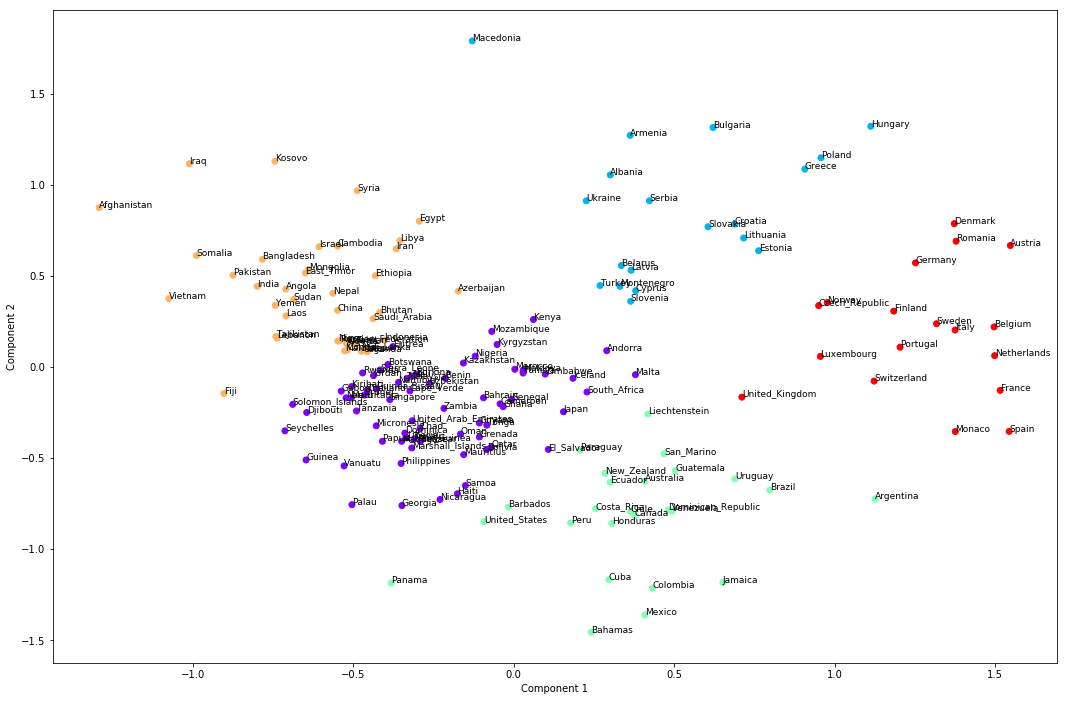

In [17]:
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def knock_97():
    country_names = joblib.load("../work/country_names.pkl")
    country_vectors = joblib.load("../work/country_vectors.pkl")
    
    pca = PCA(n_components=2, random_state=0)
    component_vectors = pca.fit_transform(country_vectors)

    model = KMeans(n_clusters=5, random_state=0)
    model.fit(component_vectors)

    fig, ax = plt.subplots()
    ax.scatter(x=component_vectors[:,0], y=component_vectors[:,1], c=model.labels_, cmap='rainbow')
    for i,(x,y) in enumerate(component_vectors):
        ax.annotate(country_names[i],(x,y), size=9)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.rcParams["figure.figsize"] = (18.0, 12.0)
    plt.show()
        
knock_97()

## 98. Ward法によるクラスタリング
96の単語ベクトルに対して，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

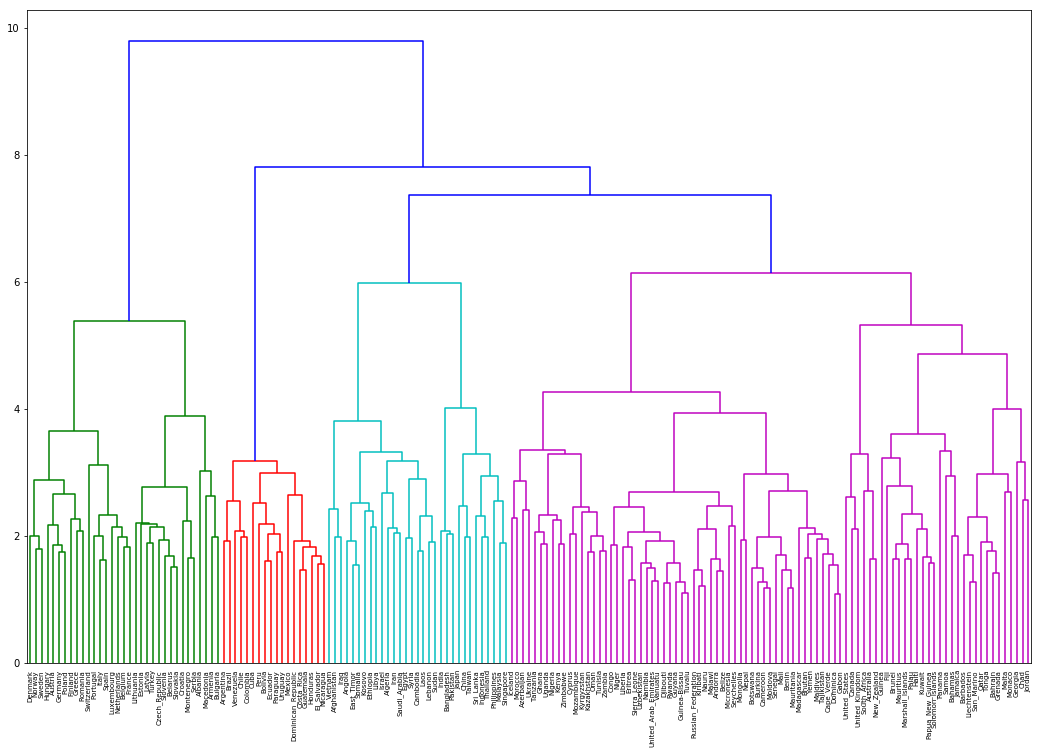

In [15]:
from sklearn.externals import joblib
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

def knock_98():
    country_names = joblib.load("../work/country_names.pkl")
    country_vectors = joblib.load("../work/country_vectors.pkl")
    model = ward(country_vectors)
    dendrogram(model, labels=country_names, leaf_font_size=7)
    plt.rcParams["figure.figsize"] = (18.0, 12.0)
    plt.show()

knock_98()

## 99. t-SNEによる可視化
96の単語ベクトルに対して，ベクトル空間をt-SNEで可視化せよ．

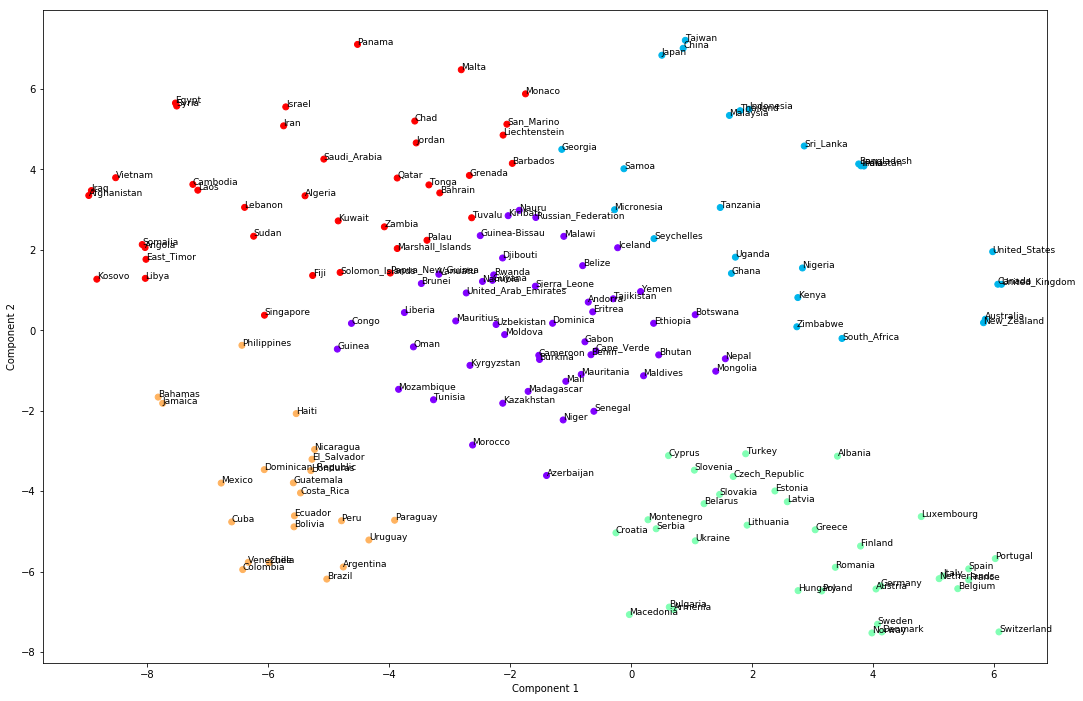

In [16]:
from sklearn.externals import joblib
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def knock_99():
    country_names = joblib.load("../work/country_names.pkl")
    country_vectors = joblib.load("../work/country_vectors.pkl")
    
    tsne = TSNE(n_components=2, random_state=0)
    component_vectors = tsne.fit_transform(country_vectors)
    
    model = KMeans(n_clusters=5, random_state=0)
    model.fit(component_vectors)

    fig, ax = plt.subplots()
    ax.scatter(x=component_vectors[:,0], y=component_vectors[:,1], c=model.labels_, cmap="rainbow")
    for i,(x,y) in enumerate(component_vectors):
        ax.annotate(country_names[i],(x,y), size=9)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.rcParams["figure.figsize"] = (18.0, 12.0)
    plt.show()
    
knock_99()